# Import packages + load data

In [1]:
import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as geom

In [2]:
#observations
rainfall = xr.open_dataset("/g/data/ng72/as9583/agcd_v1_precip_calib_r005_daily_2020.nc") # AGCD calibrated 

In [3]:
fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')

In [4]:
#surface altitude data
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf'
variable = 'surface_altitude'
experiment = 'control_d0198_RAL3P2_'
sa1 = xr.open_dataset(f'{datapath}/{variable}/{experiment}{variable}.nc')[variable].isel(time=0)

# Clip data to correct area and coordinate reference system

In [5]:
GDF = gpd.read_file("/g/data/k10/pg1235/abby_smyth_project/STE_2021_AUST_GDA2020.shp") #australia shapefile
gdf=GDF.iloc[[0,1,7]].geometry;gdf #selecting NSW, ACT,VIC

nsw_act = GDF[GDF["STE_CODE21"].isin(["1", "2", "8"])] #selecting NSW, ACT,VIC
nsw = nsw_act.dissolve(by="AUS_CODE21").geometry.iloc[0] # and dissolving them

In [6]:
nsw_gdf = gpd.GeoDataFrame(geometry=[nsw], crs=GDF.crs) 

In [7]:
#changing coordinate syst to match
gdf.crs
rainfall = rainfall.rio.write_crs("EPSG:7844")

In [8]:
getbounds = gdf.bounds;getbounds #bounds of the area of NSW, VIC and ACT 

,minx,miny,maxx,maxy
0,140.999272,-37.505147,159.109224,-28.156879
1,140.961866,-39.159176,149.976198,-33.980636
7,148.762796,-35.920517,149.399293,-35.124403


In [9]:
lat_min = getbounds.iloc[1,1]  #Minimum latitude
lat_max = getbounds.iloc[0,3]  #Maximum latitude
lon_min = getbounds.iloc[1,0]  #Minimum longitude
lon_max = getbounds.iloc[0,2]  #Maximum longitude

In [10]:
rainbox = rainfall.sel(
    lat=slice(lat_min, lat_max), 
    lon=slice(lon_min, lon_max)
) 

In [11]:
#masking just the area of interest
mask = regionmask.mask_geopandas(
    geodataframe = nsw_gdf,
    lon_or_obj = rainbox.lon.values,
    lat = rainbox.lat.values
)
rain = rainfall['precip'] 

In [13]:
# # Time window
# time_slice = slice("2020-01-12", "2020-02-15")

# # Select data for the time window
# data_period = rain.sel(time=time_slice)

# # Subset to model domain
# subset1 = data_period.sel(
#     lat=slice(-38, -29),
#     lon=slice(146, 155)
# )

# # Mask out everything except where mask == 0
# mask_subset = mask.sel(
#     lat=slice(-38, -29),
#     lon=slice(146, 155)
# )

# # Apply mask across all timesteps
# subset_masked = subset1.where(mask_subset == 0)

# # Save as NetCDF
# subset_masked.to_dataset(name="precip").to_netcdf("/g/data/ng72/as9583/stratiformrainfall/AGCD.nc")


# Plots

### Whole of NSW and Vic

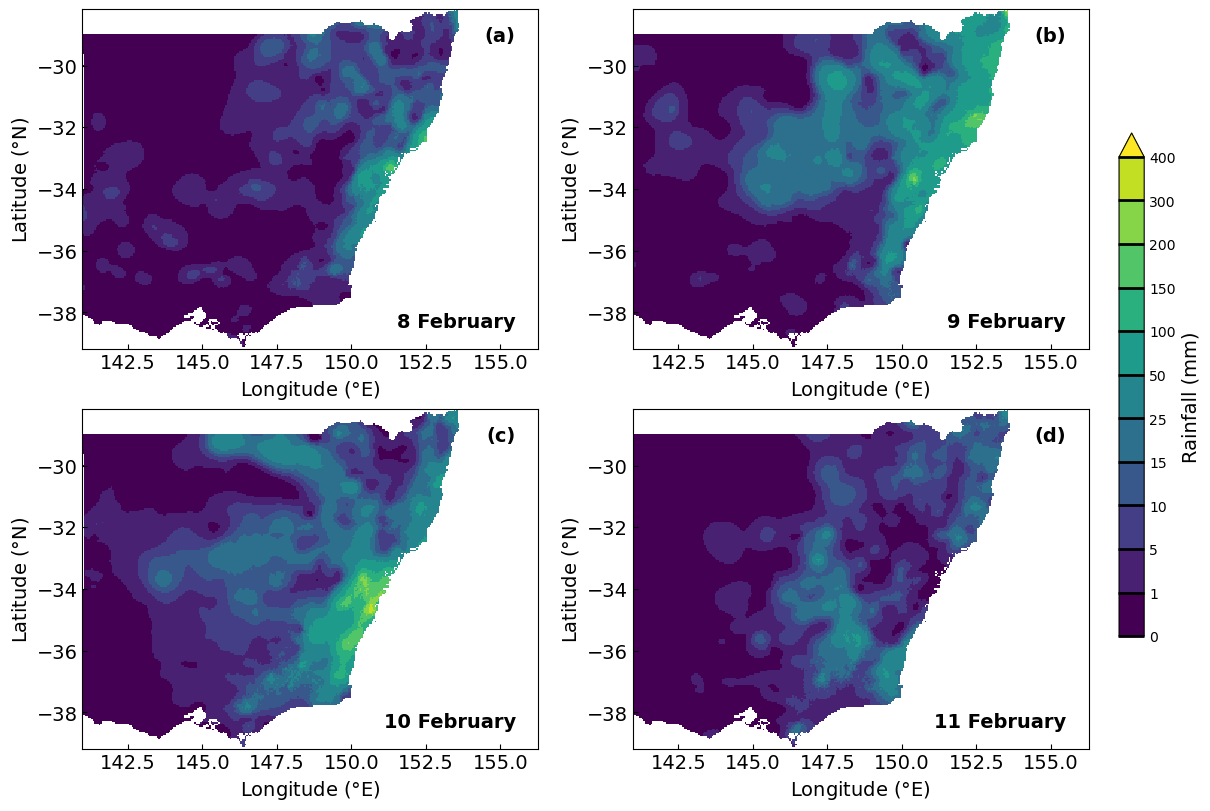

In [22]:
dates = ["2020-02-08", "2020-02-09", "2020-02-10", "2020-02-11"]
titles = ["8 February", "9 February", "10 February", "11 February"]
labels = ['a', 'b', 'c', 'd']

#matching the scale to the BoM's version
levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]

draft = True 

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

axes = axes.flatten()

#for each date from 8-11 feb, plot 
for i, date in enumerate(dates):
    masked = rain.sel(time=date).where(mask == 0)
    im = masked.plot(
        ax=axes[i],
        cmap='viridis',
        levels=levels,
        extend='max',
        add_colorbar=False
    )
    axes[i].set_title("")
    axes[i].text(
        0.95, 0.95, f"({labels[i]})",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='right'
    )
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
    )
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=14)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=14)
    axes[i].tick_params(axis='both', direction='in', labelsize=14)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=19)


if draft ==False:
    plt.savefig('/g/data/ng72/as9583/8_to_11_Feb_rain_event/BoM_recreation.png', dpi = 300)
    plt.savefig('/g/data/ng72/as9583/8_to_11_Feb_rain_event/BoM_recreation.pdf', dpi = 300)

### ACCESS-rAM3 domain, land only

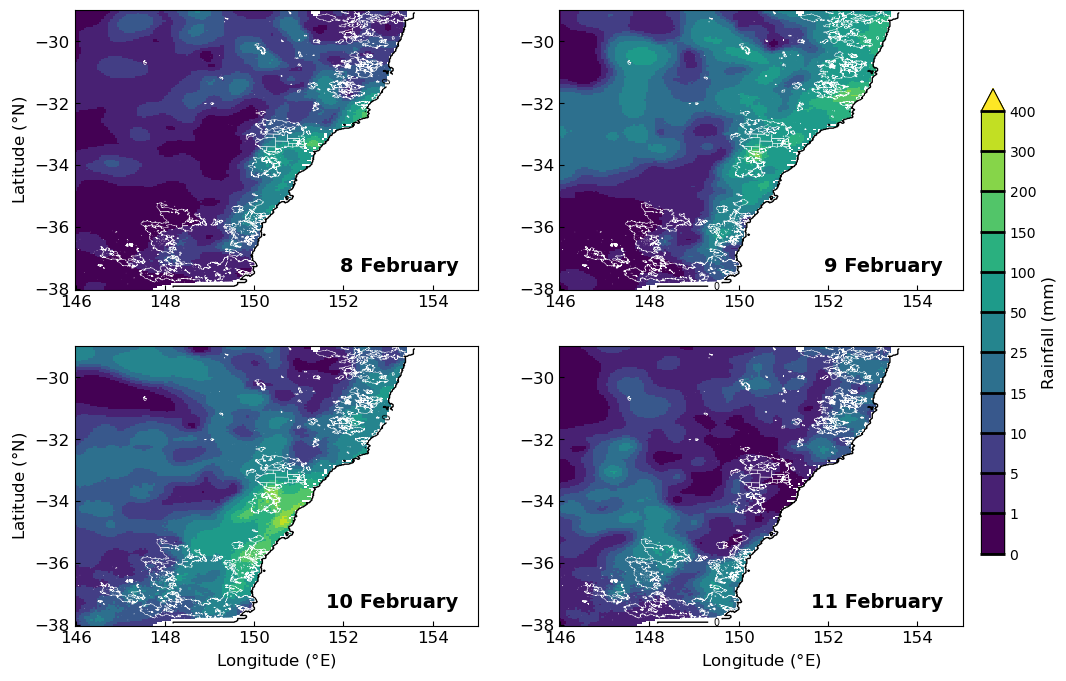

In [23]:
dates = ["2020-02-08", "2020-02-09", "2020-02-10", "2020-02-11"]
titles = ["8 February", "9 February", "10 February", "11 February"]
levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
                         # , constrained_layout=True)
axes = axes.flatten()
plt.subplots_adjust(wspace=0.2, hspace=0.2)

for i, date in enumerate(dates):
    data_on_date = rain.sel(time=date)
    
    #subset to model domain
    subset = data_on_date.sel(
        lat=slice(-38, -29),
        lon=slice(146, 155)
    )


    #mask out outside the domain
    mask_subset = mask.sel(
        lat=slice(-38, -29),
        lon=slice(146, 155)
    )

    subset = subset.where(mask_subset == 0)

    im = subset.plot(
        ax=axes[i],
        cmap='viridis',
        levels=levels,
        extend='max',
        add_colorbar=False
    )
    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)

    #plot fires
    #save current extent and aspect
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()

    #clip fires to visible extent
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)
    fires_clipped.boundary.plot(
        ax=axes[i],
        edgecolor='white',
        linewidth=0.3,
        aspect=aspect
    )
    #restore limits & aspect
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)
    
    axes[i].set_title("")
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)
axes[0].set_xlabel("", fontsize=12)
axes[1].set_xlabel("", fontsize=12)
axes[1].set_ylabel("", fontsize=12)
axes[3].set_ylabel("", fontsize=12)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=12)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=18)

# fig.savefig("/g/data/ng72/as9583/figures/event_visualisation2.png", dpi=300, bbox_inches="tight")

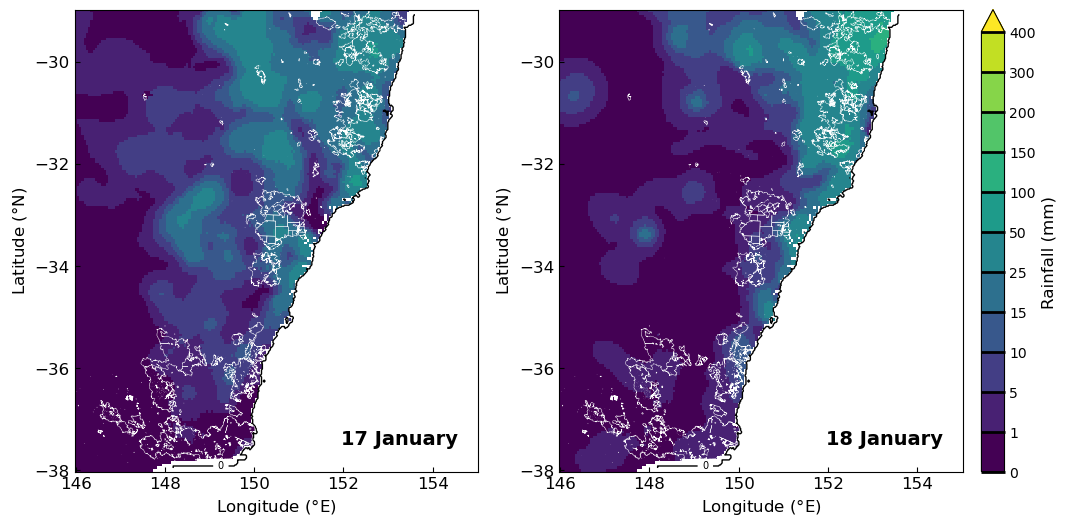

In [24]:
dates = ["2020-01-17", "2020-01-18"]
titles = ["17 January", "18 January"]
levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
                         # , constrained_layout=True)
axes = axes.flatten()
plt.subplots_adjust(wspace=0.2, hspace=0.2)

for i, date in enumerate(dates):
    data_on_date = rain.sel(time=date)
    
    # Subset to model domain
    subset = data_on_date.sel(
        lat=slice(-38, -29),
        lon=slice(146, 155)
    )


    #mask to model domain
    mask_subset = mask.sel(
        lat=slice(-38, -29),
        lon=slice(146, 155)
    )
    subset = subset.where(mask_subset == 0)

    im = subset.plot(
        ax=axes[i],
        cmap='viridis',
        levels=levels,
        extend='max',
        add_colorbar=False
    )
    contours = sa1.plot.contour(
        ax=axes[i], levels=[0], colors='black', linewidths=1, add_colorbar=False
    )
    axes[i].clabel(contours, fmt='%d', fontsize=7)

    #save current extent and aspect
    xlim = axes[i].get_xlim()
    ylim = axes[i].get_ylim()
    aspect = axes[i].get_aspect()

    #clip fires
    extent_poly = geom.box(xlim[0], ylim[0], xlim[1], ylim[1])
    fires_clipped = fires.clip(extent_poly)

    #overlay fire boundaries
    fires_clipped.boundary.plot(
        ax=axes[i],
        edgecolor='white',
        linewidth=0.3,
        aspect=aspect
    )

    #restore limits & aspect
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)
    axes[i].set_aspect(aspect)
    
    axes[i].set_title("")
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='black'
    )
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=12)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=12)
    axes[i].tick_params(axis='both', direction='in', labelsize=12)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=12)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

# fig.savefig("/g/data/ng72/as9583/figures/jan_event_visualisation.png", dpi=300, bbox_inches="tight")